# References
 - [Extreme Rare Event Classification using Autoencoders in Keras](https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098)
 - [LSTM Autoencoder for Extreme Rare Event Classification in Keras](https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb)
 - [Step-by-step understanding LSTM Autoencoder layers](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [31]:
LABELS = ['Normal', 'Break']

In [32]:
df = pd.read_csv('./data/processminer-rare-event-mts-csv.csv')
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5-1-99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5-1-99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5-1-99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5-1-99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5-1-99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [33]:
Counter(df['y'])

Counter({0: 18274, 1: 124})

## Curve Shifting
- For any row n with label 1, make (n-2):(n-1) as 1. With this, we are teaching the classifier to predict up to 4 minutes ahead. And,
- remove row n. Row n is removed because we are not interested in teaching the classifier to predict a break when it has already happened.

In [34]:
sign = lambda x: (1, -1)[x < 0]
def curve_shift(df, shift_by):
	vector = df['y'].copy()
	for s in range(abs(shift_by)):
		tmp = vector.shift(sign(shift_by))
		tmp = tmp.fillna(0)
		vector += tmp
	labelcol = 'y'
	# Add vector to the df
	df.insert(loc=0, column=labelcol+'tmp', value=vector)

	# Remove the rows with labelcol == 1.
	df = df.drop(df[df[labelcol] == 1].index)

	# Drop labelcol and rename the tmp col as labelcol
	df = df.drop(labelcol, axis=1)
	df = df.rename(columns={labelcol+'tmp': labelcol})

	# Make the labelcol binary
	df.loc[df[labelcol] > 0, labelcol] = 1

	return df

In [35]:
# shift the response column y by 2 rows to do a 4-min ahead prediction
shifted_df = curve_shift(df, shift_by=-5)
shifted_df.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,0.0,5-1-99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0.0,5-1-99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,0.0,5-1-99 0:04,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,0.0,5-1-99 0:06,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,0.0,5-1-99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [36]:
# drop remove columns
shifted_df = shifted_df.drop(['time','x28','x61'], axis=1)

## Prepare Input Data for LSTM

In [37]:
input_x = shifted_df.drop('y', axis=1).values
input_y = shifted_df['y'].values

n_features = input_x.shape[1]

In [38]:
def temporalize(X, y, timesteps):
	output_X = []
	output_y = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
		output_y.append(y[i + timesteps + 1])
	return np.squeeze(np.array(output_X)), np.array(output_y)

In [39]:
timesteps = 10

# Temporalize
x, y = temporalize(input_x, input_y, lookback)

In [40]:
# Split into train, valid, and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [41]:
print(len(x_train))
print(len(x_valid))
print(len(x_test))

11688
2922
3653


In [42]:
x_train.shape

(11688, 10, 59)

In [43]:
# For training the autoencoder, split 0 / 1
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

# Standardize the Data
- <code>flatten</code> : This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of temporalize, meaning X = flatten(temporalize(X)).
- <code>scale</code> : This function will scale a 3D array that we created as inputs to the LSTM.

In [44]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [45]:
scaler = StandardScaler().fit(flatten(x_train_y0))

x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

## LSTM Autoencoder Training

In [46]:
epochs = 200
batch = 128
lr = 0.001

In [47]:
lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            11776     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 32)            6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 59)            1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
____________________________________________________

In [48]:
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train_y0_scaled, x_train_y0_scaled,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid_y0_scaled, x_valid_y0_scaled))

Train on 11306 samples, validate on 2818 samples
Epoch 1/200
11306/11306 [==============================] - 7s 646us/sample - loss: 0.9049 - val_loss: 0.7089
Epoch 2/200
11306/11306 [==============================] - 3s 306us/sample - loss: 0.5859 - val_loss: 0.4682
Epoch 3/200
11306/11306 [==============================] - 3s 306us/sample - loss: 0.4341 - val_loss: 0.3826
Epoch 4/200
11306/11306 [==============================] - 4s 311us/sample - loss: 0.3676 - val_loss: 0.3323
Epoch 5/200
11306/11306 [==============================] - 3s 307us/sample - loss: 0.3275 - val_loss: 0.3046
Epoch 6/200
11306/11306 [==============================] - 4s 313us/sample - loss: 0.2998 - val_loss: 0.2812
Epoch 7/200
11306/11306 [==============================] - 4s 313us/sample - loss: 0.2848 - val_loss: 0.2672
Epoch 8/200
11306/11306 [==============================] - 4s 336us/sample - loss: 0.2694 - val_loss: 0.2550
Epoch 9/200
11306/11306 [==============================] - 4s 313us/sample - lo

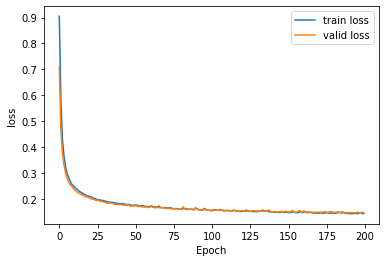

In [49]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

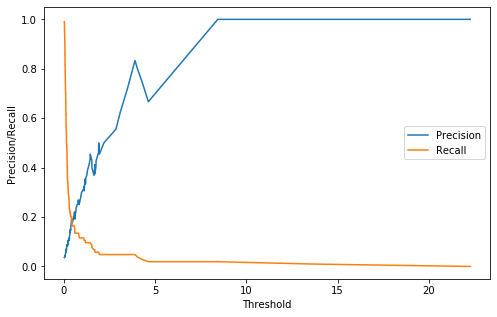

In [50]:
valid_x_predictions = lstm_ae.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [88]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.19230769230769232 , recall:  0.19230769230769232
threshold:  0.44836966709299525


In [58]:
error_df

,Reconstruction_error,True_class
0,0.136131,0.0
1,0.053580,0.0
2,0.038950,0.0
3,0.154366,0.0
4,0.063288,0.0
...,...,...
2917,0.150851,0.0
2918,0.485670,0.0
2919,0.056103,0.0
2920,1.120708,0.0


## Predict Test

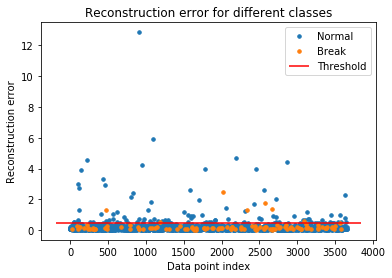

In [59]:
test_x_predictions = lstm_ae.predict(x_test_scaled)
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Evaluate Testset
### Confusion Matrix

In [60]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]
pred_y[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

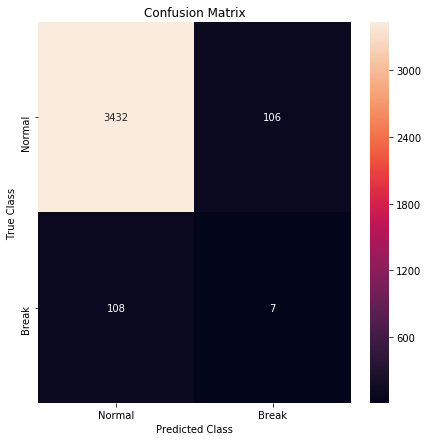

In [61]:
conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)

plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

### ROC Curve and AUC

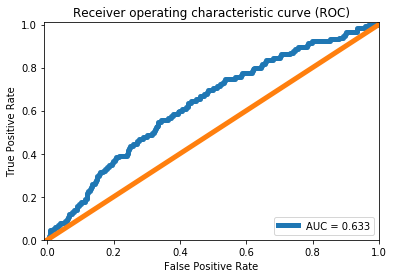

In [62]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()

In [64]:
test_x_predictions[:-5]

array([[[ 6.3760525e-01,  1.0289315e+00,  4.8805761e-01, ...,
          4.5164412e-01, -1.1201680e-02,  1.4286950e-01],
        [ 3.4312427e-01,  1.0640409e+00,  5.3510964e-01, ...,
          4.1510445e-01,  2.5029689e-02,  3.1283435e-01],
        [ 4.4836539e-01,  9.1658604e-01,  4.7383797e-01, ...,
          4.4586879e-01,  2.7355164e-02,  2.6629695e-01],
        ...,
        [ 4.4336927e-01,  9.7779751e-01,  5.1125187e-01, ...,
          4.7071797e-01,  4.0400252e-02,  2.4607590e-01],
        [ 4.4163209e-01,  9.7789109e-01,  5.1252007e-01, ...,
          4.7204226e-01,  4.0749736e-02,  2.4388823e-01],
        [ 4.3933058e-01,  9.7779036e-01,  5.1367575e-01, ...,
          4.7286695e-01,  4.0727496e-02,  2.4282929e-01]],

       [[-6.0150248e-01, -1.3127348e+00,  2.0058818e+00, ...,
         -1.7048914e+00,  2.6831627e-03, -2.4981520e-01],
        [-8.0848724e-01, -9.3527031e-01,  2.1201687e+00, ...,
         -1.9196851e+00, -4.6418667e-02, -3.1881264e-01],
        [-7.8767949e-01, 

In [67]:
pred_y[-5:]

[0, 1, 0, 0, 0]